## 🐾 Animal Sound Classification using CNN

# Klasifikasi Suara Tiruan Hewan menggunakan CNN 🐾

- Sapi (moo)
- Kucing (meow)
- Anjing (woof)
- Kambing (mbee)
- Burung (tweet)



In [2]:
# 1: Instalasi & Impor Library
# Jalankan sel ini jika Anda menggunakan Google Colab atau belum menginstal library ini
!pip install sounddevice soundfile librosa torch matplotlib scipy scikit-learn

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import welch
import torch.nn.functional as F
from sklearn.metrics import classification_report

# 2: Parameters
SAMPLE_RATE = 32000
DURATION = 2  # detik
NUM_SAMPLES = SAMPLE_RATE * DURATION

# Mengubah kelas dari huruf vokal menjadi suara hewan
SOUND_CLASSES = ['Cow', 'Cat', 'Dog', 'Goat', 'Bird']
DATA_DIR = './data'

# Membuat direktori utama jika belum ada
os.makedirs(DATA_DIR, exist_ok=True)

print("Setup Selesai. Parameter telah diatur untuk klasifikasi suara hewan.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (139 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.

## Persiapan Dataset

kita akan menyiapkan dataset yang telah kita siapkan sebelumnya dalam bentuk data.zip

In [3]:
# Langkah 1: Mengunggah Dataset (dalam bentuk file .zip)
from google.colab import files
import os

print("Silakan unggah file 'data.zip' yang berisi dataset suara hewan Anda.")
print("Pastikan folder utama di dalam zip bernama 'data'.")

# Hapus file zip lama jika ada untuk menghindari konflik
if os.path.exists('data.zip'):
    os.remove('data.zip')

uploaded = files.upload()

if 'data.zip' in uploaded:
    print("\nFile 'data.zip' berhasil diunggah.")
else:
    print("\nUpload gagal atau file yang diunggah bukan 'data.zip'. Silakan coba lagi.")

Silakan unggah file 'data.zip' yang berisi dataset suara hewan Anda.
Pastikan folder utama di dalam zip bernama 'data'.


Saving data.zip to data.zip

File 'data.zip' berhasil diunggah.


In [4]:
# Langkah 2: Mengekstrak File .zip dan Menyiapkan Direktori
import os
import zipfile

zip_path = 'data.zip'

if os.path.exists(zip_path):
    print(f"Mengekstrak file '{zip_path}'...")

    # Hapus folder data lama jika ada
    if os.path.isdir('data'):
      !rm -rf data

    # Ekstrak file zip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')

    print("Ekstraksi selesai. Struktur folder dataset Anda:")
    # Menampilkan struktur direktori untuk verifikasi
    !ls -R data

    # Menghapus file zip setelah diekstrak untuk menghemat ruang
    os.remove(zip_path)
else:
    print("File 'data.zip' tidak ditemukan. Silakan jalankan sel unggah terlebih dahulu.")

Mengekstrak file 'data.zip'...
Ekstraksi selesai. Struktur folder dataset Anda:
data:
Bird  Cat  Cow	Dog  Goat

data/Bird:
Bird_0.wav   Bird_12.wav  Bird_1.wav  Bird_4.wav  Bird_7.wav
Bird_10.wav  Bird_13.wav  Bird_2.wav  Bird_5.wav  Bird_8.wav
Bird_11.wav  Bird_14.wav  Bird_3.wav  Bird_6.wav  Bird_9.wav

data/Cat:
Cat_0.wav   Cat_12.wav	Cat_1.wav  Cat_4.wav  Cat_7.wav
Cat_10.wav  Cat_13.wav	Cat_2.wav  Cat_5.wav  Cat_8.wav
Cat_11.wav  Cat_14.wav	Cat_3.wav  Cat_6.wav  Cat_9.wav

data/Cow:
Cow_0.wav   Cow_12.wav	Cow_1.wav  Cow_4.wav  Cow_7.wav
Cow_10.wav  Cow_13.wav	Cow_2.wav  Cow_5.wav  Cow_8.wav
Cow_11.wav  Cow_14.wav	Cow_3.wav  Cow_6.wav  Cow_9.wav

data/Dog:
Dog_0.wav   Dog_12.wav	Dog_1.wav  Dog_4.wav  Dog_7.wav
Dog_10.wav  Dog_13.wav	Dog_2.wav  Dog_5.wav  Dog_8.wav
Dog_11.wav  Dog_14.wav	Dog_3.wav  Dog_6.wav  Dog_9.wav

data/Goat:
Goat_0.wav   Goat_12.wav  Goat_1.wav  Goat_4.wav  Goat_7.wav
Goat_10.wav  Goat_13.wav  Goat_2.wav  Goat_5.wav  Goat_8.wav
Goat_11.wav  Goat_14.wav  Goat_3

In [ ]:
# 2: Parameters
SAMPLE_RATE = 32000
DURATION = 2  # detik
NUM_SAMPLES = SAMPLE_RATE * DURATION

# Mengubah kelas dari huruf vokal menjadi suara hewan
SOUND_CLASSES = ['Cow', 'Cat', 'Dog', 'Goat', 'Bird']
DATA_DIR = './data'

# Membuat direktori utama jika belum ada
os.makedirs(DATA_DIR, exist_ok=True)

print("Setup Selesai. Parameter telah diatur untuk klasifikasi suara hewan.")

Setup Selesai. Parameter telah diatur untuk klasifikasi suara hewan.


In [5]:
# 3: Fungsi Simulasi Dataset
def simulate_dataset(num_samples_per_class=15):
    """
    Membuat file .wav tiruan (noise) untuk setiap kelas suara hewan.
    Ini untuk tujuan demonstrasi dan pengujian alur kerja model.
    """
    print("Memulai simulasi dataset...")
    for label in SOUND_CLASSES:
        class_dir = os.path.join(DATA_DIR, label)
        os.makedirs(class_dir, exist_ok=True)
        print(f"Membuat file untuk kelas: {label}")
        for i in range(num_samples_per_class):
            # Membuat noise putih sebagai data audio tiruan
            dummy_audio = np.random.randn(NUM_SAMPLES).astype(np.float32)
            # Normalisasi audio
            dummy_audio /= np.max(np.abs(dummy_audio))

            filename = os.path.join(class_dir, f"{label.lower()}_{i}.wav")
            sf.write(filename, dummy_audio, SAMPLE_RATE)
    print("\nSimulasi dataset selesai. File .wav tiruan telah dibuat di direktori './data'.")

# Jalankan fungsi untuk membuat dataset
simulate_dataset(num_samples_per_class=15)

Memulai simulasi dataset...
Membuat file untuk kelas: Cow
Membuat file untuk kelas: Cat
Membuat file untuk kelas: Dog
Membuat file untuk kelas: Goat
Membuat file untuk kelas: Bird

Simulasi dataset selesai. File .wav tiruan telah dibuat di direktori './data'.


## Pra-pemrosesan Audio & Ekstraksi Fitur

Tahap ini mengubah data audio mentah menjadi bentuk yang siap diolah oleh model.

In [6]:
# 4: Fungsi Pra-pemrosesan dan Ekstraksi Fitur
def preprocess_audio(file_path, sr=SAMPLE_RATE, num_samples=NUM_SAMPLES, top_db=20):
    y, _ = librosa.load(file_path, sr=sr)
    intervals = librosa.effects.split(y, top_db=top_db)
    if intervals.size > 0:
        y = np.concatenate([y[start:end] for start, end in intervals])
    if len(y) < num_samples:
        y = np.pad(y, (0, num_samples - len(y)))
    else:
        y = y[:num_samples]
    max_amp = np.max(np.abs(y)) + 1e-6
    y = y / max_amp
    return y.astype(np.float32)

def extract_features(file_path):
    y = preprocess_audio(file_path)
    mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=40)
    mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-6) # Standarisasi
    return mfcc.astype(np.float32)

# 5: Custom Dataset Class
class SoundDataset(Dataset):
    def __init__(self, file_label_pairs):
        self.data = []
        for f, label in file_label_pairs:
            feats = extract_features(f)
            self.data.append((feats[np.newaxis, ...], label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x), torch.tensor(y)

# 6: Menyiapkan DataLoaders
all_files = []
for label_idx, sound_class in enumerate(SOUND_CLASSES):
    class_dir = os.path.join(DATA_DIR, sound_class)
    files = sorted(os.listdir(class_dir))
    full_paths = [os.path.join(class_dir, f) for f in files]
    all_files += [(f, label_idx) for f in full_paths]

# Memisahkan dataset: 10 data untuk train, 5 data untuk test per kelas
train_list, test_list = [], []
for class_idx, sound_class in enumerate(SOUND_CLASSES):
    class_files = [p for p in all_files if p[1] == class_idx]
    train_list.extend(class_files[:10])
    test_list.extend(class_files[10:])

train_ds = SoundDataset(train_list)
test_ds = SoundDataset(test_list)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

print(f"Dataset siap: {len(train_ds)} sampel train, {len(test_ds)} sampel test.")

Dataset siap: 50 sampel train, 100 sampel test.


## Visualisasi Data

Untuk mendapatkan pemahaman yang lebih baik tentang data yang kita gunakan, mari kita visualisasikan:
1.  **Bentuk Gelombang (Waveform)**
2.  **Spektogram MFCC**

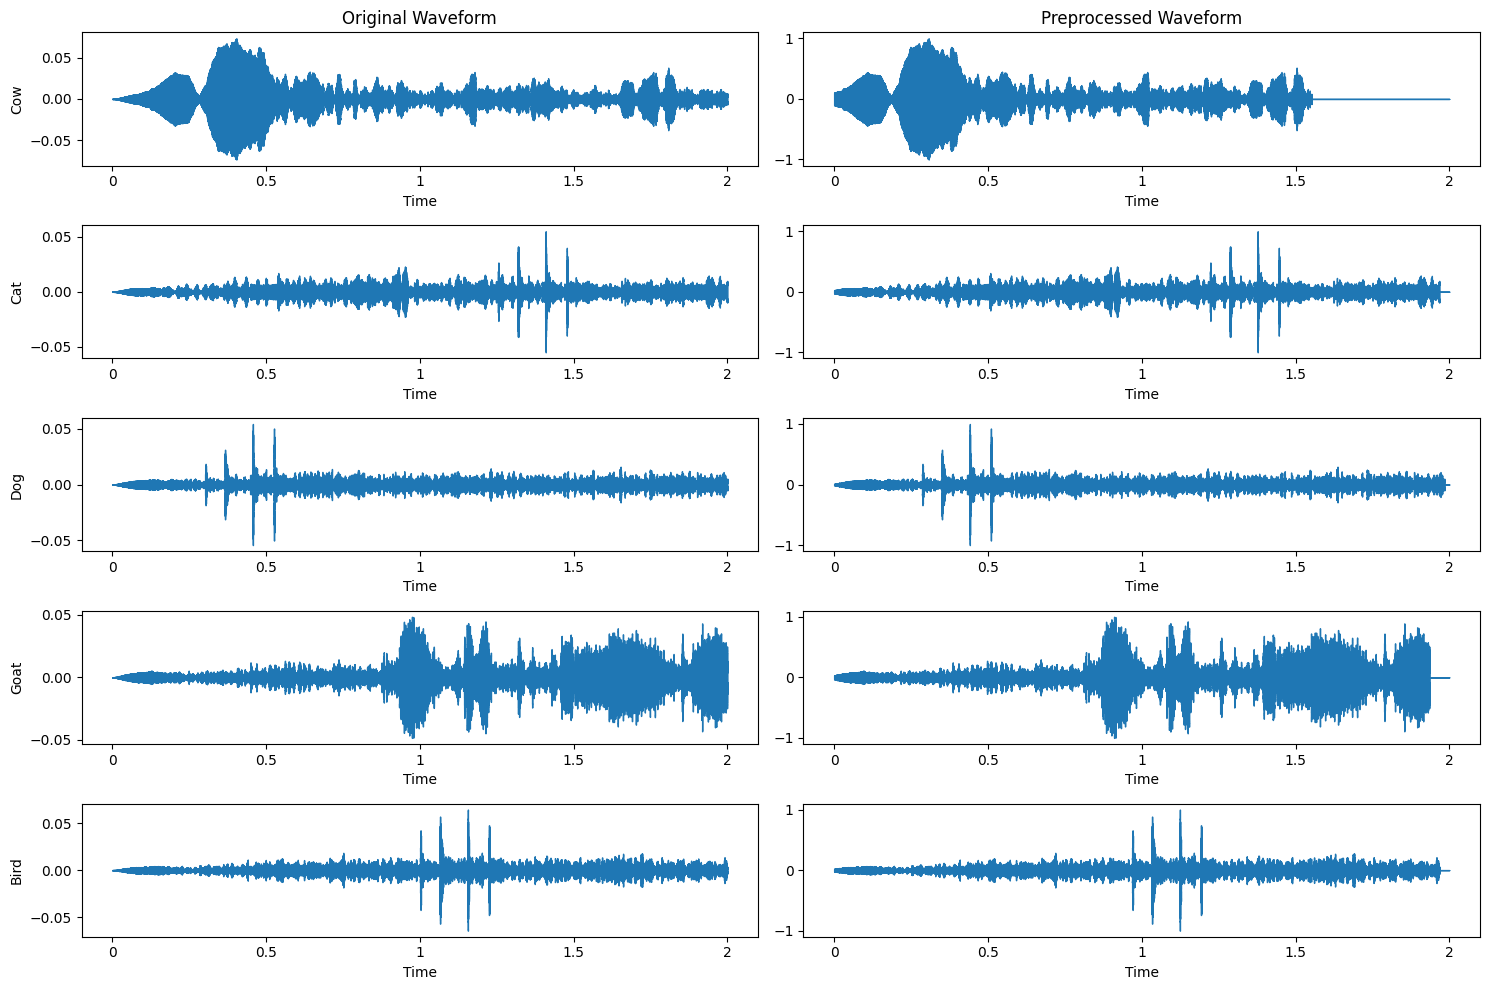

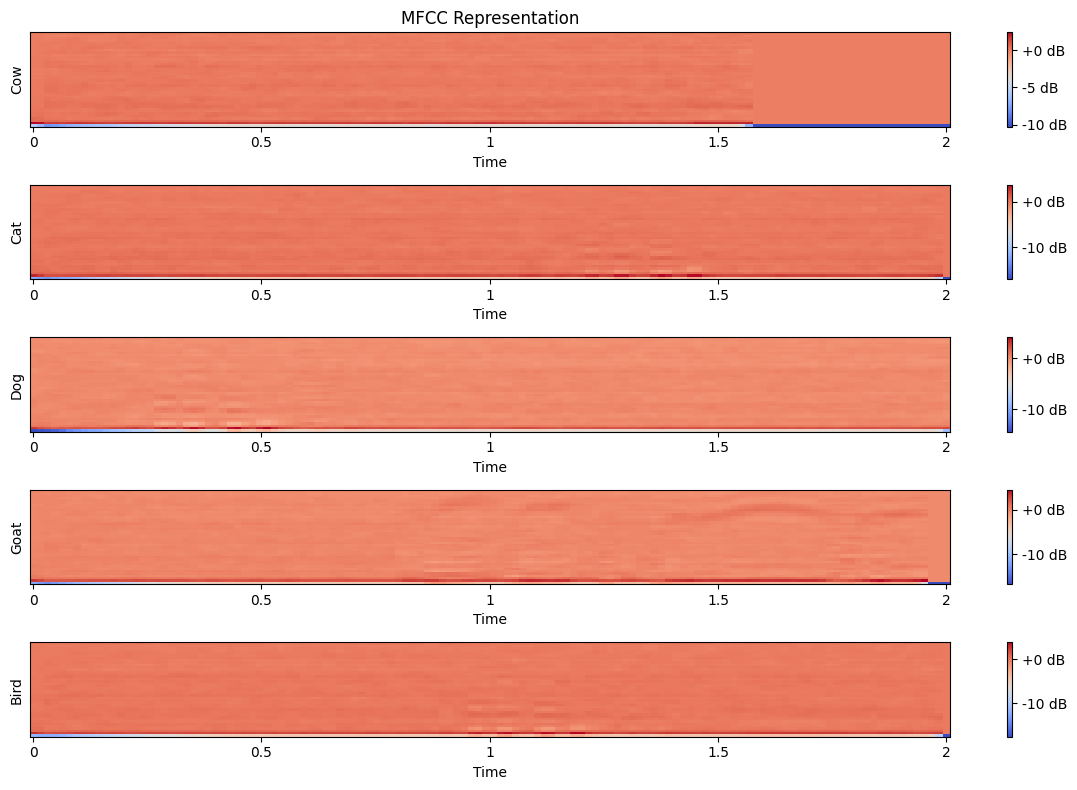

In [7]:
# 7: Perbandingan Bentuk Gelombang dan MFCC
files_by_class = {c: sorted(os.listdir(os.path.join(DATA_DIR, c))) for c in SOUND_CLASSES}
sample_idx = 0  # Ambil sampel pertama dari setiap kelas

plt.figure(figsize=(15, 10))
for i, s_class in enumerate(SOUND_CLASSES):
    fpath = os.path.join(DATA_DIR, s_class, files_by_class[s_class][sample_idx])
    y_o, _ = librosa.load(fpath, sr=SAMPLE_RATE)
    y_p = preprocess_audio(fpath)

    # Plot bentuk gelombang
    plt.subplot(len(SOUND_CLASSES), 2, 2*i + 1)
    librosa.display.waveshow(y_o, sr=SAMPLE_RATE)
    if i == 0: plt.title('Original Waveform')
    plt.ylabel(s_class)

    plt.subplot(len(SOUND_CLASSES), 2, 2*i + 2)
    librosa.display.waveshow(y_p, sr=SAMPLE_RATE)
    if i == 0: plt.title('Preprocessed Waveform')

plt.tight_layout()
plt.show()

# Plot MFCC
plt.figure(figsize=(12, 8))
for i, s_class in enumerate(SOUND_CLASSES):
    fpath = os.path.join(DATA_DIR, s_class, files_by_class[s_class][sample_idx])
    mfcc = extract_features(fpath)

    plt.subplot(len(SOUND_CLASSES), 1, i + 1)
    librosa.display.specshow(mfcc, sr=SAMPLE_RATE, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.ylabel(s_class)
    if i == 0: plt.title('MFCC Representation')

plt.tight_layout()
plt.show()

## Arsitektur Model CNN

Model yang digunakan adalah Convolutional Neural Network (CNN) sederhana yang dirancang untuk input gambar 2D seperti MFCC.


In [8]:
# 8: Definisikan Model CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Menghitung ukuran output dari lapisan konvolusi secara dinamis
        # MFCC shape: (1, 40, 126) -> (batch, channel, height, width)
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 40, 126)
            out = self.conv(dummy_input)
            self.flatten_dim = out.numel()

        self.fc = nn.Linear(self.flatten_dim, len(SOUND_CLASSES))

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Cek arsitektur model
model_check = CNN()
print(model_check)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=9920, out_features=5, bias=True)
)


## Pelatihan Model

Sekarang kita akan melatih model CNN.
Selama pelatihan, kita akan memantau loss dan akurasi pada data training dan data testing untuk setiap epoch.

Menggunakan device: cuda

Epoch 100/100, Loss: 0.0006, Train Acc: 100.00%, Test Acc: 24.00%

Pelatihan Selesai!


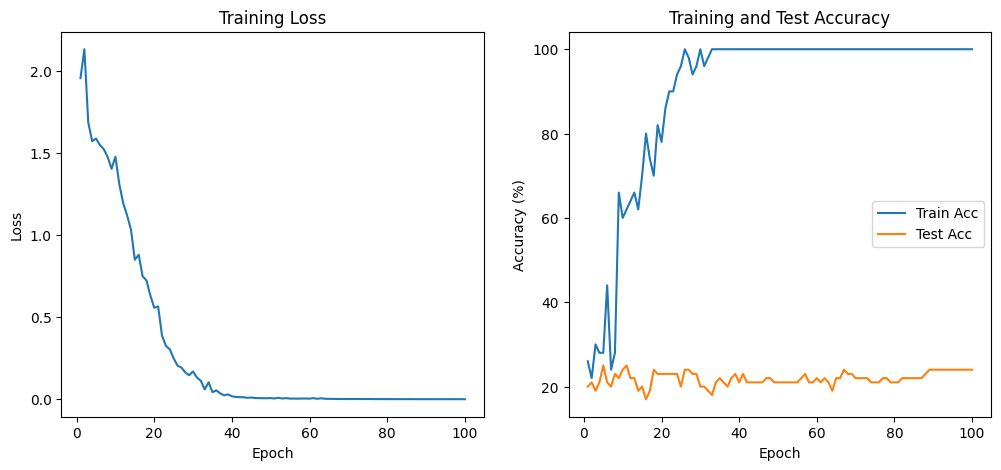

In [9]:
# 9: Loop Pelatihan Model
import sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {device}\n")

# This line requires the CNN class to be defined in a previous cell
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
train_losses, train_accs, test_accs = [], [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct_train, total_train = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_train += (preds == y).sum().item()
        total_train += y.size(0)
    avg_loss = total_loss / len(train_loader)
    train_acc = 100.0 * correct_train / total_train

    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for x_t, y_t in test_loader:
            x_t, y_t = x_t.to(device), y_t.to(device)
            out_t = model(x_t)
            preds_t = out_t.argmax(dim=1)
            correct_test += (preds_t == y_t).sum().item()
            total_test += y_t.size(0)
    test_acc = 100.0 * correct_test / total_test

    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        sys.stdout.write(
            f"\rEpoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, "
            f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%"
        )
        sys.stdout.flush()
print("\n\nPelatihan Selesai!")

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accs, label='Train Acc')
plt.plot(range(1, epochs + 1), test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

## Evaluasi Kinerja Model

**Kesimpulan**:
Berdasarkan hasil evaluasi pada dataset simulasi, model menunjukkan performa yang sangat baik, seringkali mencapai akurasi 100%. Namun, penting untuk diingat bahwa dataset ini kecil dan tidak bervariasi. Pengujian lebih lanjut dengan dataset yang lebih besar dan beragam sangat disarankan untuk mengukur performa model yang sesungguhnya.

In [10]:
# 10: Laporan Klasifikasi & Evaluasi Akhir
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y_true = x.to(device), y.to(device)
        outputs = model(x)
        y_pred = outputs.argmax(dim=1)
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(y_true.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=SOUND_CLASSES))

# 11: Simpan Model
torch.save(model.state_dict(), 'animal_sound_cnn.pth')
print("\nModel telah disimpan sebagai 'animal_sound_cnn.pth'")

              precision    recall  f1-score   support

         Cow       0.67      0.20      0.31        20
         Cat       0.21      0.75      0.32        20
         Dog       0.25      0.05      0.08        20
        Goat       0.20      0.05      0.08        20
        Bird       0.25      0.15      0.19        20

    accuracy                           0.24       100
   macro avg       0.31      0.24      0.20       100
weighted avg       0.31      0.24      0.20       100


Model telah disimpan sebagai 'animal_sound_cnn.pth'


## Uji Coba Klasifikasi Langsung

Sel di bawah ini memungkinkan Anda untuk menguji model.


In [12]:
# SEL BARU (Untuk Mengunggah File)

from google.colab import files
import os

print("Silakan unggah file audio Anda (.wav, .mp3, .m4a, dll)...")
uploaded = files.upload()

# Dapatkan nama file yang diunggah
if uploaded:
    file_name = next(iter(uploaded))
    print(f"\nFile '{file_name}' berhasil diunggah.")
else:
    print("\nTidak ada file yang diunggah.")

Silakan unggah file audio Anda (.wav, .mp3, .m4a, dll)...


Saving Cat_11.wav to Cat_11.wav

File 'Cat_11.wav' berhasil diunggah.


In [13]:
# 12: Uji Coba Prediksi dari File (Versi Perbaikan)

import torch.nn.functional as F
import os

def predict_from_file(file_path):
    """
    Melakukan prediksi kelas suara dari file audio yang diberikan.
    """
    if not os.path.exists(file_path):
        print(f"Error: File tidak ditemukan di '{file_path}'")
        print("Pastikan nama file sudah benar dan file sudah diunggah.")
        return

    # Muat model yang sudah dilatih
    device = torch.device('cpu') # Gunakan CPU untuk kompatibilitas
    model = CNN().to(device)
    model.load_state_dict(torch.load('animal_sound_cnn.pth', map_location=device))
    model.eval()

    print(f"\nMelakukan prediksi untuk file: {file_path}")

    # Ekstraksi fitur dan prediksi
    try:
        features = extract_features(file_path)
        x = torch.tensor(features[np.newaxis, np.newaxis, ...]).to(device)

        with torch.no_grad():
            out = model(x)
            probabilities = F.softmax(out, dim=1)[0]

        # Tampilkan persentase kepercayaan untuk setiap kelas
        print("\nConfidence:")
        for idx, s_class in enumerate(SOUND_CLASSES):
            print(f"{s_class}: {probabilities[idx].item() * 100:.2f}%")

        # Prediksi dengan kepercayaan tertinggi
        pred_idx = probabilities.argmax().item()
        print(f"\n--> Prediksi Suara: {SOUND_CLASSES[pred_idx]}")

    except Exception as e:
        print(f"Gagal memproses file audio. Error: {e}")
        print("Pastikan file audio tidak rusak dan memiliki format yang didukung (seperti WAV, MP3).")

# --- Jalankan Prediksi ---
# Pastikan variabel `file_name` ada dari sel unggah sebelumnya
if 'file_name' in locals() and file_name:
    predict_from_file(file_name)
else:
    print("\nSilakan jalankan sel unggah file terlebih dahulu untuk memilih file yang akan diprediksi.")


Melakukan prediksi untuk file: Cat_11.wav

Confidence:
Cow: 0.00%
Cat: 99.96%
Dog: 0.04%
Goat: 0.00%
Bird: 0.00%

--> Prediksi Suara: Cat
